In [1]:
import zipfile

import matplotlib.pyplot as plt
import pandas as pd
import re
import glob
from bs4 import BeautifulSoup
from datasets import Dataset
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [2]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    model_name="gpt-2", chunk_size=300, chunk_overlap=100
)

In [3]:
newspapers = ['Bataafsche staats-courant',
 'Koninglyke staats-courant',
 'Koninklĳke courant',
 'Nederlandsche staatscourant',
 'Bataviasche koloniale courant',
 "Journal du département des bouches du Rhin",
 "'s Gravenhaagsche courant", 
 "Java government gazette"]

In [4]:
filepaths = ["raw/delpher_newspapers/kranten_pd_180x.zip", "raw/delpher_newspapers/kranten_pd_181x.zip"]

In [5]:
ds_path = "datasets_all/delpher-subset"

In [6]:
data_all = []

In [7]:
# get newspapers which are mentioned from zips
for filepath in filepaths:
    with zipfile.ZipFile(filepath, "r") as zf:
        for file_name in zf.namelist():
            if file_name.endswith('.tsv'):
                print(file_name)
                with zf.open(file_name) as f:
                    data = pd.read_csv(f, sep = '\t', index_col=False, names=["Newspaper", "Date", "Origin", "Filepath"], header=None)
                    data = data[data['Newspaper'].isin(newspapers)]
                    data_all.append(data)

index_kranten_pd_180x.tsv
index_kranten_pd_181x.tsv


In [8]:
data_comb = pd.concat(data_all, ignore_index=True)
data_comb["Filepath"] = [x[2:] for x in data_comb["Filepath"]]

In [9]:
# data_comb[data_comb["Date"].str.contains("1813")]["Newspaper"].unique()

In [10]:
data_comb_graph = data_comb[['Newspaper', "Date"]]
data_comb_graph['Date'] = data_comb_graph['Date'].apply(pd.to_datetime)
data_comb_graph['Year'] = [int(x.year) for x in data_comb_graph['Date']]

C:\Users\imruh\AppData\Local\Temp\ipykernel_38548\1399133108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_comb_graph['Date'] = data_comb_graph['Date'].apply(pd.to_datetime)
C:\Users\imruh\AppData\Local\Temp\ipykernel_38548\1399133108.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_comb_graph['Year'] = [int(x.year) for x in data_comb_graph['Date']]


In [11]:
plot_df = pd.DataFrame({'Count' : data_comb_graph.groupby(["Newspaper", "Year"] ).size()}).reset_index()

In [12]:
# plot_df = plot_df.query('Year==1811|Year==1812|Year==1813')

In [13]:
plot_df

,Newspaper,Year,Count
0,'s Gravenhaagsche courant,1813,42
1,'s Gravenhaagsche courant,1814,157
2,'s Gravenhaagsche courant,1815,156
3,'s Gravenhaagsche courant,1816,157
4,'s Gravenhaagsche courant,1817,157
5,'s Gravenhaagsche courant,1818,156
6,'s Gravenhaagsche courant,1819,157
7,Bataafsche staats-courant,1805,69
8,Bataafsche staats-courant,1806,75
9,Bataviasche koloniale courant,1810,52


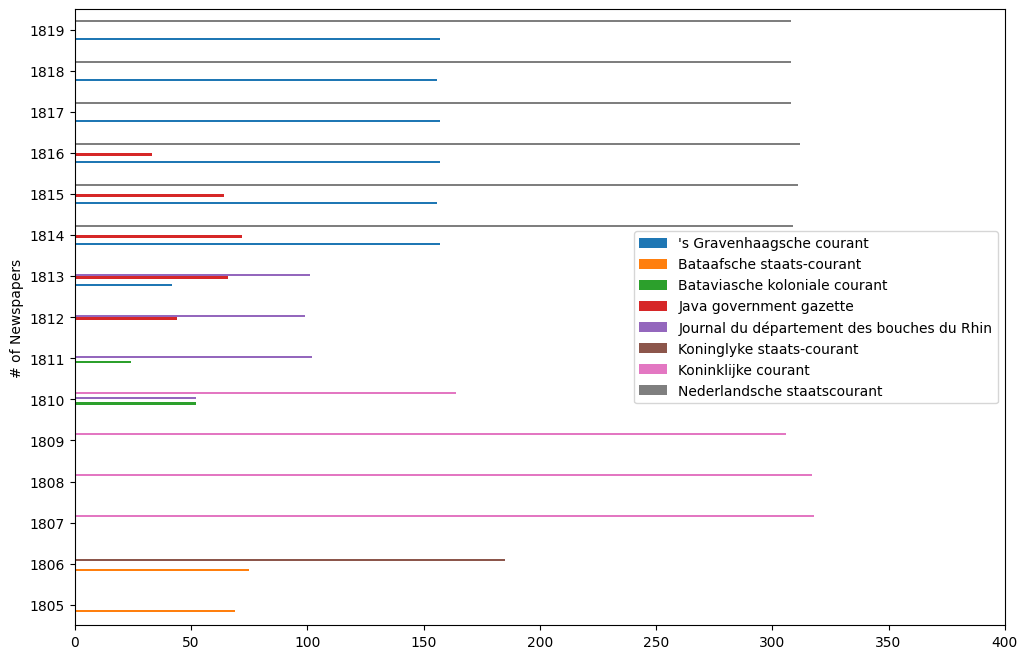

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_df.pivot(index="Year", columns="Newspaper", values="Count").plot(kind="barh", ax=ax)
ax.legend(loc = "center right", ncol=1)
plt.ylabel("# of Newspapers")
plt.xlim(0, 400)
plt.show()

In [15]:
print(f"# of newspapers: {len(data_comb.Filepath.unique())}, start: {sorted(data_comb.Date.unique())[0]}, end: {sorted(data_comb.Date.unique())[-1]}") 

# of newspapers: 4981, start: 1805-09-04, end: 1819-12-31


In [16]:
newspaper_list = []

# data split level
for filepath in filepaths:
    print(f"Filepath: {filepath}")
    with zipfile.ZipFile(filepath, "r", ) as zf:

        all_files = data_comb[data_comb["Origin"].str.contains(re.split('/', filepath)[-1])]["Filepath"]
        all_newspapers = data_comb[data_comb["Origin"].str.contains(re.split('/', filepath)[-1])]["Newspaper"]
        all_dates = data_comb[data_comb["Origin"].str.contains(re.split('/', filepath)[-1])]["Date"]

        for f, newspaper, date in zip(all_files, all_newspapers, all_dates):
            print(f"    On file {f}")
            # Newspaper level
            xml_files = [x for x in zf.namelist() if f in x and x.endswith("articletext.xml")]
            articles = []

            # Article level
            for xml_file in xml_files:
                with zf.open(xml_file) as s:
                    xml_content = s.read().decode("utf-8")
                    soup = BeautifulSoup(xml_content, 'xml')
                    title = soup.find('title').text
                    paras = [x.text for x in soup.find_all('p')]
                    paras = " \n ".join(paras)
                    paras = text_splitter.split_text(paras)
                    for para in paras:
                        newspaper_list.append([int(date.split("-")[0]), int(date.split("-")[1]), int(date.split("-")[2]), newspaper, xml_file, title, para])

newspaper_contents = pd.DataFrame(newspaper_list, columns=["Year", "Month", "Day", "Newspaper","Path","Title", "Text"])
ds = Dataset.from_pandas(newspaper_contents)
ds.save_to_disk(ds_path)

Filepath: raw/delpher_newspapers/kranten_pd_180x.zip
    On file 1805/09/04/DDD_ddd_010084054_mpeg21/
    On file 1805/09/06/DDD_ddd_010084055_mpeg21/
    On file 1805/09/09/DDD_ddd_010084056_mpeg21/
    On file 1805/09/11/DDD_ddd_010084057_mpeg21/
    On file 1805/09/13/DDD_ddd_010084058_mpeg21/
    On file 1805/09/16/DDD_ddd_010084059_mpeg21/
    On file 1805/09/18/DDD_ddd_010084060_mpeg21/
    On file 1805/09/20/DDD_ddd_010084061_mpeg21/
    On file 1805/09/23/DDD_ddd_010084062_mpeg21/
    On file 1805/09/24/DDD_ddd_010084063_mpeg21/
    On file 1805/09/25/DDD_ddd_010084064_mpeg21/
    On file 1805/09/27/DDD_ddd_010084065_mpeg21/
    On file 1805/09/28/DDD_ddd_010084066_mpeg21/
    On file 1805/09/30/DDD_ddd_010084067_mpeg21/
    On file 1805/09/30/DDD_ddd_010084068_mpeg21/
    On file 1805/10/02/DDD_ddd_010084069_mpeg21/
    On file 1805/10/04/DDD_ddd_010084070_mpeg21/
    On file 1805/10/07/DDD_ddd_010084071_mpeg21/
    On file 1805/10/07/DDD_ddd_010084072_mpeg21/
    On file 1805

Saving the dataset (0/1 shards):   0%|          | 0/486703 [00:00<?, ? examples/s]

In [17]:
ds = Dataset.load_from_disk(ds_path)